# Comparison between different models for the Kaggle challenge "SETI Breakthrough Listen"

In this notebook, I will train some EfficientNetV2 models and validate the results in the context of the "SETI Breakthrough Listen" challenge hosted by Kaggle. Accordingly, the dataset given from the challenge is used to train and to validate the models.

## Import packages
First, the packages used in the notebook are imported.

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import metrics
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sn
import torch
import torch.nn as nn
import random
import albumentations as A
from efficientnet_pytorch import model as enet
from sklearn.model_selection import StratifiedKFold
import codecs
from PIL import Image
import copy

## Set the seed
To be able to reproduce the results, the seed must be set before partitioning the data and training the network. Omitting this part will break the idempotence of the code and therefore leads to different results when executed multiple times.

In [2]:
def set_seed(seed = 0):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    return random_state

random_state = set_seed(2021)

## Check if CUDA can be used
Due to the efficiency boost given from training on the graphics processing unit, the following code checks if CUDA can be used. This only works with NVIDIA graphic cards.

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


## Load and analyse the data

The aim is now to load the data and to gain some first insights (a very small exploratory data analysis) from it.

First, the annotations/labels for the train data are loaded into a pandas dataframe.

In [4]:
df_train=pd.read_csv('./train_labels.csv')
df_train.head()

,id,target
0,0000799a2b2c42d,0
1,00042890562ff68,0
2,0005364cdcb8e5b,0
3,0007a5a46901c56,0
4,0009283e145448e,0


Then, the file id's are mapped into the corresponding file path.

In [5]:
df_train['img_path']=df_train['id'].apply(lambda x:f'./train/{x[0]}/{x}.npy')
df_train.head()

,id,target,img_path
0,0000799a2b2c42d,0,./train/0/0000799a2b2c42d.npy
1,00042890562ff68,0,./train/0/00042890562ff68.npy
2,0005364cdcb8e5b,0,./train/0/0005364cdcb8e5b.npy
3,0007a5a46901c56,0,./train/0/0007a5a46901c56.npy
4,0009283e145448e,0,./train/0/0009283e145448e.npy


Finally, we also want to gain knowledge about the distribution of the data: How many data images are classified as anomalies (Target = 1)?

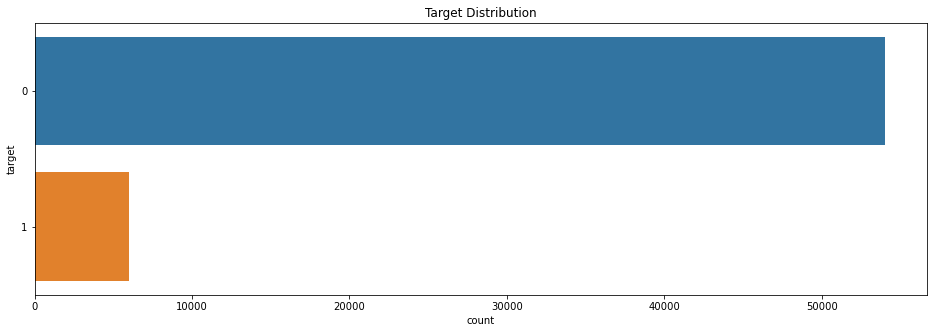

There are 6000 cadences with an abnormal signal, and 54000 without.
Therefore the relative frequency of cadences with abnormal signals is: 10.0%.


In [6]:
plt.figure(figsize=(16, 5))
sn.countplot(y="target", data=df_train)
plt.title("Target Distribution");
plt.show()
print(f"There are {len(df_train[df_train['target'] == 1])} cadences with an abnormal signal, "
      + f"and {len(df_train[df_train['target'] == 0])} without.")
print("Therefore the relative frequency of cadences with abnormal signals is: "
      + f"{len(df_train[df_train['target'] == 1]) / len(df_train) * 100}%.")

## Define the Dataset and the Neural Network classes

Now we want to define the classes for the dataset and the neural network which we will use to train.

First, we define our dataset in the following class. It takes the following parameters:
* The image: The cadence as given by the .npy files from the dataset
* The label (target): The annotation which gives the information if the image contains abnormal signals (target = 1) or not (target = 0)
* The augmentation: This is an Albumentations object which contains a transformation instruction for the cadences to create augmented training data. It can be None if no augmentation should be applied onto the data samples.

Here, the preprocessing contains two steps. First, the image is stacked vertically and then transposed (swap axis).
After that, the image is resized to 512x512.

To demonstrate how this looks like, an example is shown for a cadence before and after the preprocessing.

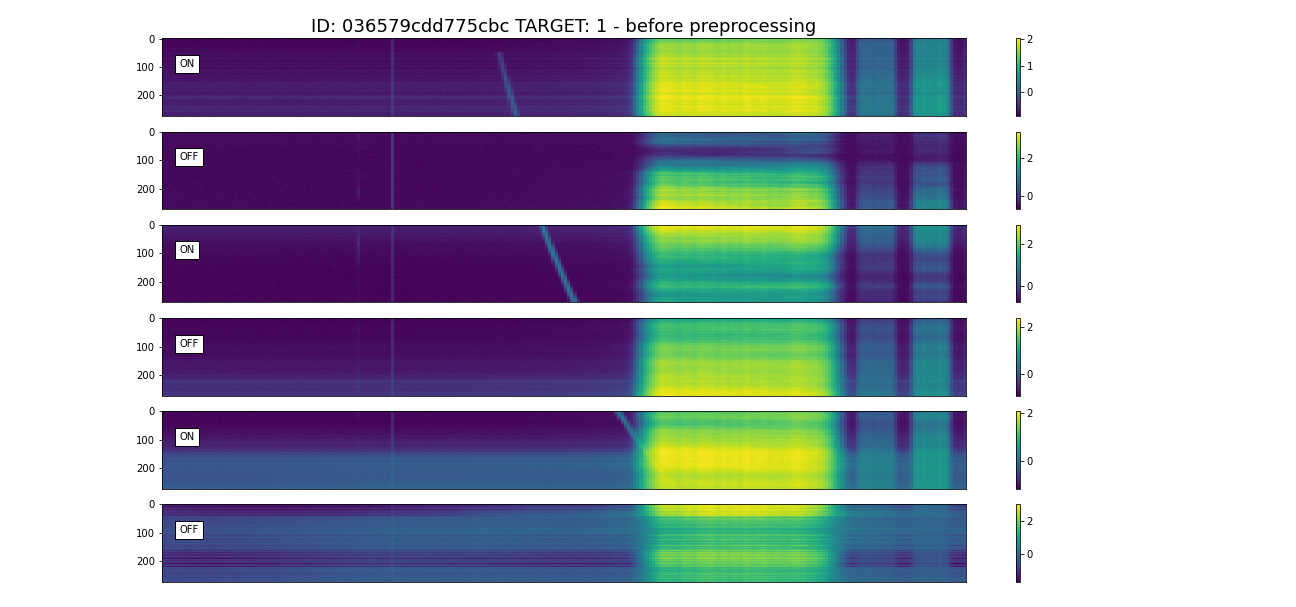

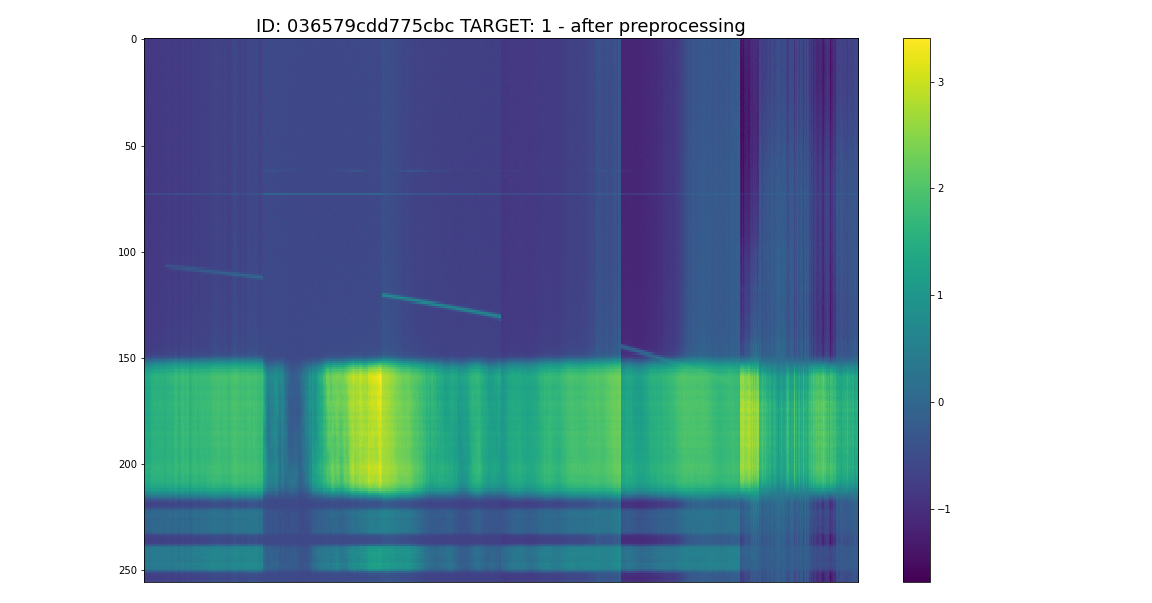

In [7]:
class ClassificationDataset:
    
    def __init__(self, image_paths, targets, augment=None): 
        self.image_paths = image_paths
        self.targets = targets
        self.augment = augment

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, item):      
        # Load the image and the annotation into the class properties
        image = np.load(self.image_paths[item]).astype(float)
        targets = self.targets[item]
        
        # Preprocessing part
        # Image Preprocessing: Stack vertically, transpose and resize to 512 x 512 
        
        image = np.vstack(image).transpose((1, 0))
        img_pl = Image.fromarray(image).resize((512, 512), resample=Image.BICUBIC)
        image = np.array(img_pl)
            
        # Augmentation part
        if self.augment:
            image = self.augment(image=image)['image']
            
        return {
            "image": torch.from_numpy(image).unsqueeze(dim=0),
            "targets": torch.tensor(targets, dtype=torch.long),
        }

Next, the neural network will be defined. As only EfficientnetV2 networks are used, it is not a generic class and therefore only suitable for those networks.

The class takes the following parameters:
* The backbone: the name of the Network to use, e.g. "efficientnet-b1"
* The pretrained file: a path string to a ".pth" file with a pretrained model. Can be None if no model with pretrained weights should be used.
* The output dimension: The amount of output neurons which is 1 here as we have a classification task (target = 1 or target = 0)

To insert a cadence into the network, some convolution filters are used to have a fitting dimension for the efficientnet input layers.

The extract method injects the image into the EfficientNet network.
The forward method executes the entire forward pass which contains the first convolution and pooling operations and then calls the extract method. At the end, a linear layer is used to calculate the output neuron. 

In [8]:
class enetv2(nn.Module):
    def __init__(self, backbone, pretrained_file=None, out_dim=1):
        super(enetv2, self).__init__()
        self.enet = enet.EfficientNet.from_name(backbone)
        if pretrained_file is not None and os.path.isfile(pretrained_file):
            self.enet.load_state_dict(torch.load(pretrained_file))
        self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)
        self.enet._fc = nn.Identity()
        self.conv1Norm = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=3, bias=False)
        self.poolNorm = nn.MaxPool2d(2, 2)
        self.conv2Norm = nn.Conv2d(32, 3, kernel_size=3, bias=False)

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        x = self.conv1Norm(x)
        x = self.poolNorm(x)
        x = self.conv2Norm(x)
        x = self.extract(x)
        x = self.myfc(x)
        return x

## Define train and evaluation function

The following two functions are crucial to optimize the network. Both are quite similar, so both will be explained together. They take the following parameters:

* The data loader: A PyTorch object which contains the dataset.
* The model: The neural network which is going to be trained/evaluated.
* The optimizer: The optimization algorithm used. Here it is Adam. (only needed in train as the model weights are not changed in evaluation mode)
* The device: CPU or CUDA, depending on what the CUDA check

Inside the functions, the inputs are first loaded into the GPU or CPU (depending if CUDA is used). Then the gradients are reset to prevent double counting as they sum up usually (this is only needed in the train function as the gradients are not calculated in the evaluation step). Then, the forward pass is calculated (data goes through the CNN). After that, the loss is calculated. The evaluation functions ends at this point, but in the train function the gradients are calculated and the neuron weights updated after to accomplish the train step.

Both functions return the mean loss and the evaluation function also returns the output predictions and the true output label.

In [9]:
def train(data_loader, model, optimizer, device):
    model.train() # Sets to train mode
    running_loss = 0
    i = 0
    
    for data in tqdm(data_loader, position=0, leave=True, desc='Training'):
        i += 1
        inputs = data["image"]
        targets = data['targets']
        
        # Load the data into the GPU/CPU
        inputs = inputs.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.float)
        
        optimizer.zero_grad() # Reset the gradients of the model parameters to prevent double-counting
        outputs = model(inputs) # Calculate forward pass
        loss = nn.BCEWithLogitsLoss()(outputs, targets.view(-1, 1)) # Calculate loss
        loss.backward() # Calculate gradients
        optimizer.step() # Update neuron weights
        
        running_loss += loss.item()
        
    return running_loss / i
        
def evaluate(data_loader, model, device):
    model.eval() # Sets to evaluation mode
    
    final_targets = []
    final_outputs = []
    
    with torch.no_grad():
        running_loss = 0
        i = 0
        
        for data in tqdm(data_loader, position=0, leave=True, desc='Evaluating'):
            i += 1
            inputs = data["image"]
            targets = data["targets"]
            
            # Load the data into the GPU/CPU
            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device, dtype=torch.float)
            
            output = model(inputs) # Calculate forward pass
            running_loss += nn.BCEWithLogitsLoss()(output, targets.view(-1, 1)).item() # Calculate loss
            targets = targets.detach().cpu().numpy().tolist()
            output = output.detach().cpu().numpy().tolist()
            
            final_targets.extend(targets)
            final_outputs.extend(output)
            
    return final_outputs, final_targets, running_loss / i

## Define the hyperparameters and the needed information
Before we begin to train the models, we need to prepare some parameters:

* The models are defined and the model names and paths to the pretrained models (those need to be downloaded before) are set.
* The hyperparameters are defined: batch size, amount of folds, learn rate for the optimizer, amount of epochs
* The data is partitioned into train and validation data using a Stratified-K-Fold (see https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py for more information) -> Cross Validation is used
* The log file is created

In [10]:
baseline_name = ['efficientnet-b1', 'efficientnet-b3', 'efficientnet-b5'] # Neural Networks to use
pretrained_model = {
    baseline_name[0]: './checkpoint/efficientnet-b1-dbc7070a.pth', # Path to the pretrained models
    baseline_name[1]: './checkpoint/efficientnet-b3-c8376fa2.pth',
    baseline_name[2]: './checkpoint/efficientnet-b5-586e6cc6.pth'
}
models = []
Batch_Size = 8
folds = 4
learn_rate = 5e-4
log_file = 'results.log'
X = df_train.img_path.values
Y = df_train.target.values
skf = StratifiedKFold(n_splits=folds)

starter_models = [enetv2(baseline_name[0], pretrained_file=pretrained_model[baseline_name[0]], out_dim=1),
                  enetv2(baseline_name[1], pretrained_file=pretrained_model[baseline_name[1]], out_dim=1),
                  enetv2(baseline_name[2], pretrained_file=pretrained_model[baseline_name[2]], out_dim=1),
                  enetv2(baseline_name[0], pretrained_file=pretrained_model[baseline_name[0]], out_dim=1),
                  enetv2(baseline_name[1], pretrained_file=pretrained_model[baseline_name[1]], out_dim=1),
                  enetv2(baseline_name[2], pretrained_file=pretrained_model[baseline_name[2]], out_dim=1)]

names = ['efficientnet-b1', 'efficientnet-b3', 'efficientnet-b5',
        'efficientnet-b1-augment', 'efficientnet-b3-augment', 'efficientnet-b5-augment']

epochs = 5
aurocs = [[[] for i in range(folds)] for i in names]

#create log file
codecs.open(log_file, 'w+');

## The core: train the networks

This is the main part: Every model is trained on the folds created from the train-test-split. The first three models are trained without data augmentation, after training those, new models from the same type are trained based on the augmented data.

In [11]:
it = 0

for model in starter_models:
    best_roc_auc = 0
    fold = 0
    for train_index, test_index in skf.split(X, Y):
        
        # Second half - images are augmented
        if it > 2:
            train_augment = A.Compose([
                        # Flip the image
                        A.VerticalFlip(p=0.5),
                        # CoarseDropout creates holes in the images (sets pixels in that area to zero)
                        A.CoarseDropout(max_height=int(512 * 0.1), max_width=int(512 * 0.1), max_holes=5, p=0.5),
                        ])
        # First half - no augmentation
        else:
            train_augment = None
        
        # The models are created again to not reuse the old ones
        starter_models = [enetv2(baseline_name[0], pretrained_file=pretrained_model[baseline_name[0]], out_dim=1),
                          enetv2(baseline_name[1], pretrained_file=pretrained_model[baseline_name[1]], out_dim=1),
                          enetv2(baseline_name[2], pretrained_file=pretrained_model[baseline_name[2]], out_dim=1)]
        
        model = starter_models[it % 3]
        
        # Load the model onto the device
        model.to(device)

        train_images, valid_images = X[train_index], X[test_index]
        train_targets, valid_targets = Y[train_index], Y[test_index]

        train_dataset = ClassificationDataset(image_paths=train_images, targets=train_targets, augment=train_augment)
        valid_dataset = ClassificationDataset(image_paths=valid_images, targets=valid_targets, augment=None)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=Batch_Size,shuffle=True, num_workers=4)
        valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=Batch_Size,shuffle=False, num_workers=4)

        # Define the optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
        
        train_loss = 0
        
        for epoch in range(epochs):
            # In the fourth epoch, the learn rate is decreased to prevent big changes in the last few epochs.
            if epoch == 4:
                for param_group in optimizer.param_groups:
                    param_group["lr"] = 1e-4
            
            train_loss = train(train_loader, model, optimizer, device=device)
            predictions, valid_targets, valid_loss = evaluate(valid_loader, model, device=device)
            # The AUROC metric is calculated based on the predictions and the true targets
            roc_auc = metrics.roc_auc_score(valid_targets, predictions)
            # Save result for visualization later
            aurocs[it][fold].append(roc_auc)
            
            if roc_auc > best_roc_auc:
                best_roc_auc = roc_auc
                
            # Write result for this epoch to the log file.
            print(f"Model={names[it]}, Fold {fold}: Epoch={epoch}, Train Loss={train_loss}, Validation Loss={valid_loss}, Validation ROC AUC={roc_auc}")
            with codecs.open(log_file, 'a') as up:
                up.write(f"Model={names[it]}, Fold={fold}, Epoch={epoch}, Valid ROC AUC={roc_auc}/{best_roc_auc}\n")

            if roc_auc > best_roc_auc:
                print(f"New best AUROC: Model={names[it]}, Fold {fold}: Epoch={epoch}, Validation ROC AUC={roc_auc}")
                torch.save(model.state_dict(), baseline_name + '-' + str(fold) + '-' + str(epoch) + '.pt')
                best_roc_auc = roc_auc

        models.append(model)
        fold += 1
    it += 1

Evaluating: 100%|████████████████████████████| 1875/1875 [01:16<00:00, 24.55it/s]


Model=efficientnet-b1, Fold 0: Epoch=0, Train Loss=0.2538037712679969, Validation Loss=0.20819047698378562, Validation ROC AUC=0.8106622716049383


Evaluating: 100%|████████████████████████████| 1875/1875 [01:15<00:00, 24.80it/s]


Model=efficientnet-b1, Fold 0: Epoch=1, Train Loss=0.21427932505872516, Validation Loss=0.2132311812793215, Validation ROC AUC=0.8074902962962963


Evaluating: 100%|████████████████████████████| 1875/1875 [01:15<00:00, 24.85it/s]


Model=efficientnet-b1, Fold 0: Epoch=2, Train Loss=0.19999582696987522, Validation Loss=0.19945652823944887, Validation ROC AUC=0.8257202716049381


Evaluating: 100%|████████████████████████████| 1875/1875 [01:15<00:00, 24.75it/s]


Model=efficientnet-b1, Fold 0: Epoch=3, Train Loss=0.1919287382685476, Validation Loss=0.20759169675037265, Validation ROC AUC=0.8288643456790123


Evaluating: 100%|████████████████████████████| 1875/1875 [01:15<00:00, 24.84it/s]


Model=efficientnet-b1, Fold 0: Epoch=4, Train Loss=0.16699464697589478, Validation Loss=0.18434479383975266, Validation ROC AUC=0.8466271111111111


Evaluating: 100%|████████████████████████████| 1875/1875 [01:16<00:00, 24.44it/s]


Model=efficientnet-b1, Fold 1: Epoch=0, Train Loss=0.25636100537843176, Validation Loss=0.21555492471059162, Validation ROC AUC=0.8065873086419754


Evaluating: 100%|████████████████████████████| 1875/1875 [01:16<00:00, 24.67it/s]


Model=efficientnet-b1, Fold 1: Epoch=1, Train Loss=0.21257909412549603, Validation Loss=0.20783099952538808, Validation ROC AUC=0.804274938271605


Evaluating: 100%|████████████████████████████| 1875/1875 [01:16<00:00, 24.55it/s]


Model=efficientnet-b1, Fold 1: Epoch=2, Train Loss=0.19927917681634427, Validation Loss=0.19420671228468417, Validation ROC AUC=0.8358483950617284


Evaluating: 100%|████████████████████████████| 1875/1875 [01:15<00:00, 24.72it/s]


Model=efficientnet-b1, Fold 1: Epoch=3, Train Loss=0.1892425628989935, Validation Loss=0.1944737228622039, Validation ROC AUC=0.8461526419753087


Evaluating: 100%|████████████████████████████| 1875/1875 [01:15<00:00, 24.74it/s]


Model=efficientnet-b1, Fold 1: Epoch=4, Train Loss=0.1634274597591824, Validation Loss=0.18226188025226195, Validation ROC AUC=0.8587872839506174


Evaluating: 100%|████████████████████████████| 1875/1875 [01:15<00:00, 24.89it/s]


Model=efficientnet-b1, Fold 2: Epoch=0, Train Loss=0.264406321828564, Validation Loss=0.20728807491163412, Validation ROC AUC=0.8239185432098767


Evaluating: 100%|████████████████████████████| 1875/1875 [01:14<00:00, 25.08it/s]


Model=efficientnet-b1, Fold 2: Epoch=1, Train Loss=0.21740989120668835, Validation Loss=0.2098396133594215, Validation ROC AUC=0.8349601234567902


Evaluating: 100%|████████████████████████████| 1875/1875 [01:15<00:00, 24.73it/s]


Model=efficientnet-b1, Fold 2: Epoch=2, Train Loss=0.20196101358599133, Validation Loss=0.19473217001358667, Validation ROC AUC=0.8320102962962963


Evaluating: 100%|████████████████████████████| 1875/1875 [01:14<00:00, 25.11it/s]


Model=efficientnet-b1, Fold 2: Epoch=3, Train Loss=0.19315237677560912, Validation Loss=0.18473571180502574, Validation ROC AUC=0.8496164938271605


Evaluating: 100%|████████████████████████████| 1875/1875 [01:16<00:00, 24.48it/s]


Model=efficientnet-b1, Fold 2: Epoch=4, Train Loss=0.16937944176759984, Validation Loss=0.17634945533623297, Validation ROC AUC=0.860559975308642


Evaluating: 100%|████████████████████████████| 1875/1875 [01:14<00:00, 25.04it/s]


Model=efficientnet-b1, Fold 3: Epoch=0, Train Loss=0.25905608860419854, Validation Loss=0.2074629339804252, Validation ROC AUC=0.8262011604938273


Evaluating: 100%|████████████████████████████| 1875/1875 [01:14<00:00, 25.20it/s]


Model=efficientnet-b1, Fold 3: Epoch=1, Train Loss=0.21503534813788203, Validation Loss=0.19688916611075402, Validation ROC AUC=0.817180938271605


Evaluating: 100%|████████████████████████████| 1875/1875 [01:14<00:00, 25.13it/s]


Model=efficientnet-b1, Fold 3: Epoch=2, Train Loss=0.20131758254898918, Validation Loss=0.18990083804527919, Validation ROC AUC=0.834113901234568


Evaluating: 100%|████████████████████████████| 1875/1875 [01:14<00:00, 25.08it/s]


Model=efficientnet-b1, Fold 3: Epoch=3, Train Loss=0.19329721644918124, Validation Loss=0.19252555834949017, Validation ROC AUC=0.8471046666666666


Evaluating: 100%|████████████████████████████| 1875/1875 [01:15<00:00, 24.99it/s]


Model=efficientnet-b1, Fold 3: Epoch=4, Train Loss=0.16957537767820888, Validation Loss=0.17747278222491344, Validation ROC AUC=0.8613042469135803


Evaluating: 100%|████████████████████████████| 1875/1875 [01:16<00:00, 24.64it/s]


Model=efficientnet-b3, Fold 0: Epoch=0, Train Loss=0.2505759078012572, Validation Loss=0.21698244711558023, Validation ROC AUC=0.80285787654321


Evaluating: 100%|████████████████████████████| 1875/1875 [01:15<00:00, 24.74it/s]


Model=efficientnet-b3, Fold 0: Epoch=1, Train Loss=0.21333332376645672, Validation Loss=0.20238595806360246, Validation ROC AUC=0.8256113086419754


Evaluating: 100%|████████████████████████████| 1875/1875 [01:15<00:00, 24.69it/s]


Model=efficientnet-b3, Fold 0: Epoch=2, Train Loss=0.199244082761142, Validation Loss=0.19562878260463476, Validation ROC AUC=0.8388803209876543


Evaluating: 100%|████████████████████████████| 1875/1875 [01:16<00:00, 24.64it/s]


Model=efficientnet-b3, Fold 0: Epoch=3, Train Loss=0.18770414203024574, Validation Loss=0.19676148259341716, Validation ROC AUC=0.8390817777777778


Evaluating: 100%|████████████████████████████| 1875/1875 [01:14<00:00, 25.14it/s]


Model=efficientnet-b3, Fold 0: Epoch=4, Train Loss=0.16196241769691308, Validation Loss=0.18044991483092307, Validation ROC AUC=0.8545532345679012


Evaluating: 100%|████████████████████████████| 1875/1875 [01:15<00:00, 24.85it/s]


Model=efficientnet-b3, Fold 1: Epoch=0, Train Loss=0.2595753151502874, Validation Loss=0.21421596097747486, Validation ROC AUC=0.7996582222222224


Evaluating: 100%|████████████████████████████| 1875/1875 [01:16<00:00, 24.45it/s]


Model=efficientnet-b3, Fold 1: Epoch=1, Train Loss=0.21656729184488455, Validation Loss=0.2080024123340845, Validation ROC AUC=0.8031466172839506


Evaluating: 100%|████████████████████████████| 1875/1875 [01:15<00:00, 24.92it/s]


Model=efficientnet-b3, Fold 1: Epoch=2, Train Loss=0.19979855664521456, Validation Loss=0.2017442766537269, Validation ROC AUC=0.8179434074074075


Evaluating: 100%|████████████████████████████| 1875/1875 [01:15<00:00, 24.87it/s]


Model=efficientnet-b3, Fold 1: Epoch=3, Train Loss=0.19094641976919438, Validation Loss=0.19272652169118326, Validation ROC AUC=0.8421907901234568


Evaluating: 100%|████████████████████████████| 1875/1875 [01:15<00:00, 24.74it/s]


Model=efficientnet-b3, Fold 1: Epoch=4, Train Loss=0.16480012730227575, Validation Loss=0.18271359868049622, Validation ROC AUC=0.8529624197530865


Evaluating: 100%|████████████████████████████| 1875/1875 [01:16<00:00, 24.45it/s]


Model=efficientnet-b3, Fold 2: Epoch=0, Train Loss=0.2537057986895243, Validation Loss=0.21580173941055933, Validation ROC AUC=0.8104231111111111


Evaluating: 100%|████████████████████████████| 1875/1875 [01:16<00:00, 24.65it/s]


Model=efficientnet-b3, Fold 2: Epoch=1, Train Loss=0.21505133770505588, Validation Loss=0.19840488020380337, Validation ROC AUC=0.8321461728395062


Evaluating: 100%|████████████████████████████| 1875/1875 [01:15<00:00, 24.84it/s]


Model=efficientnet-b3, Fold 2: Epoch=2, Train Loss=0.2002895227495167, Validation Loss=0.18896929284632205, Validation ROC AUC=0.8478421234567901


Evaluating: 100%|████████████████████████████| 1875/1875 [01:16<00:00, 24.48it/s]


Model=efficientnet-b3, Fold 2: Epoch=3, Train Loss=0.19178510892738898, Validation Loss=0.18475713930924734, Validation ROC AUC=0.8567065679012346


Evaluating: 100%|████████████████████████████| 1875/1875 [01:15<00:00, 24.85it/s]


Model=efficientnet-b3, Fold 2: Epoch=4, Train Loss=0.16583427745997906, Validation Loss=0.17815390925357738, Validation ROC AUC=0.863399950617284


Evaluating: 100%|████████████████████████████| 1875/1875 [01:15<00:00, 24.82it/s]


Model=efficientnet-b3, Fold 3: Epoch=0, Train Loss=0.253115203253097, Validation Loss=0.21939455859760443, Validation ROC AUC=0.8060624938271606


Evaluating: 100%|████████████████████████████| 1875/1875 [01:16<00:00, 24.52it/s]


Model=efficientnet-b3, Fold 3: Epoch=1, Train Loss=0.21304813521471289, Validation Loss=0.19938691804905734, Validation ROC AUC=0.8307424197530864


Evaluating: 100%|████████████████████████████| 1875/1875 [01:17<00:00, 24.33it/s]


Model=efficientnet-b3, Fold 3: Epoch=2, Train Loss=0.2002209381138285, Validation Loss=0.20979050015409786, Validation ROC AUC=0.8124342716049382


Evaluating: 100%|████████████████████████████| 1875/1875 [01:15<00:00, 24.68it/s]


Model=efficientnet-b3, Fold 3: Epoch=3, Train Loss=0.19129632307257918, Validation Loss=0.19276548215448858, Validation ROC AUC=0.8450860000000001


Evaluating: 100%|████████████████████████████| 1875/1875 [01:15<00:00, 24.84it/s]


Model=efficientnet-b3, Fold 3: Epoch=4, Train Loss=0.16414604113598666, Validation Loss=0.17737844397872687, Validation ROC AUC=0.8579388641975308


Evaluating: 100%|████████████████████████████| 1875/1875 [01:28<00:00, 21.14it/s]


Model=efficientnet-b5, Fold 0: Epoch=0, Train Loss=0.2583281278388368, Validation Loss=0.21461951067547003, Validation ROC AUC=0.806550938271605


Evaluating: 100%|████████████████████████████| 1875/1875 [01:30<00:00, 20.68it/s]


Model=efficientnet-b5, Fold 0: Epoch=1, Train Loss=0.21273740250186787, Validation Loss=0.2046128940433264, Validation ROC AUC=0.8338873086419752


Evaluating: 100%|████████████████████████████| 1875/1875 [01:30<00:00, 20.69it/s]


Model=efficientnet-b5, Fold 0: Epoch=2, Train Loss=0.19970573310719597, Validation Loss=0.18838365504443647, Validation ROC AUC=0.8410365185185185


Evaluating: 100%|████████████████████████████| 1875/1875 [01:30<00:00, 20.65it/s]


Model=efficientnet-b5, Fold 0: Epoch=3, Train Loss=0.18671176661931807, Validation Loss=0.18753291506071884, Validation ROC AUC=0.8452516543209877


Evaluating: 100%|████████████████████████████| 1875/1875 [01:30<00:00, 20.74it/s]


Model=efficientnet-b5, Fold 0: Epoch=4, Train Loss=0.15940239502622022, Validation Loss=0.17731460698495308, Validation ROC AUC=0.8562941234567901


Evaluating: 100%|████████████████████████████| 1875/1875 [01:29<00:00, 21.04it/s]


Model=efficientnet-b5, Fold 1: Epoch=0, Train Loss=0.26390866837468413, Validation Loss=0.240121797311306, Validation ROC AUC=0.7587134320987654


Evaluating: 100%|████████████████████████████| 1875/1875 [01:29<00:00, 21.05it/s]


Model=efficientnet-b5, Fold 1: Epoch=1, Train Loss=0.21682579686625136, Validation Loss=0.2014913417607546, Validation ROC AUC=0.8303244197530864


Evaluating: 100%|████████████████████████████| 1875/1875 [01:29<00:00, 20.91it/s]


Model=efficientnet-b5, Fold 1: Epoch=2, Train Loss=0.2001239976859755, Validation Loss=0.19610954672992228, Validation ROC AUC=0.8412446419753087


Evaluating: 100%|████████████████████████████| 1875/1875 [01:28<00:00, 21.17it/s]


Model=efficientnet-b5, Fold 1: Epoch=3, Train Loss=0.18789225608872043, Validation Loss=0.1965481449852387, Validation ROC AUC=0.8332590370370372


Evaluating: 100%|████████████████████████████| 1875/1875 [01:28<00:00, 21.08it/s]


Model=efficientnet-b5, Fold 1: Epoch=4, Train Loss=0.16050434690482088, Validation Loss=0.1826383885656794, Validation ROC AUC=0.850075925925926


Evaluating: 100%|████████████████████████████| 1875/1875 [01:29<00:00, 21.01it/s]


Model=efficientnet-b5, Fold 2: Epoch=0, Train Loss=0.2607240028060145, Validation Loss=0.22966213860114415, Validation ROC AUC=0.8036537283950618


Evaluating: 100%|████████████████████████████| 1875/1875 [01:29<00:00, 20.91it/s]


Model=efficientnet-b5, Fold 2: Epoch=1, Train Loss=0.21861294358736938, Validation Loss=0.20901076032519342, Validation ROC AUC=0.8307747160493827


Evaluating: 100%|████████████████████████████| 1875/1875 [01:30<00:00, 20.69it/s]


Model=efficientnet-b5, Fold 2: Epoch=2, Train Loss=0.2000136050192846, Validation Loss=0.18963310571511585, Validation ROC AUC=0.8491368888888888


Evaluating: 100%|████████████████████████████| 1875/1875 [01:30<00:00, 20.70it/s]


Model=efficientnet-b5, Fold 2: Epoch=3, Train Loss=0.1899417609969775, Validation Loss=0.18040739729305108, Validation ROC AUC=0.8567876790123456


Evaluating: 100%|████████████████████████████| 1875/1875 [01:30<00:00, 20.78it/s]


Model=efficientnet-b5, Fold 2: Epoch=4, Train Loss=0.16326452650924525, Validation Loss=0.1724708282435934, Validation ROC AUC=0.8649066172839506


Evaluating: 100%|████████████████████████████| 1875/1875 [01:29<00:00, 20.97it/s]


Model=efficientnet-b5, Fold 3: Epoch=0, Train Loss=0.27140814830164117, Validation Loss=0.22040230455994606, Validation ROC AUC=0.8113152098765433


Evaluating: 100%|████████████████████████████| 1875/1875 [01:28<00:00, 21.19it/s]


Model=efficientnet-b5, Fold 3: Epoch=1, Train Loss=0.21862459201018017, Validation Loss=0.19815013501644135, Validation ROC AUC=0.8374577283950618


Evaluating: 100%|████████████████████████████| 1875/1875 [01:28<00:00, 21.14it/s]


Model=efficientnet-b5, Fold 3: Epoch=2, Train Loss=0.19940682612823116, Validation Loss=0.19772406475345294, Validation ROC AUC=0.8265277283950616


Evaluating: 100%|████████████████████████████| 1875/1875 [01:29<00:00, 20.88it/s]


Model=efficientnet-b5, Fold 3: Epoch=3, Train Loss=0.18924223559002082, Validation Loss=0.18664608175555866, Validation ROC AUC=0.8473897037037037


Evaluating: 100%|████████████████████████████| 1875/1875 [01:28<00:00, 21.08it/s]


Model=efficientnet-b5, Fold 3: Epoch=4, Train Loss=0.16186802998847433, Validation Loss=0.17408981241832178, Validation ROC AUC=0.8651776790123455


Evaluating: 100%|████████████████████████████| 1875/1875 [01:15<00:00, 24.94it/s]


Model=efficientnet-b1-augment, Fold 0: Epoch=0, Train Loss=0.2650891830596659, Validation Loss=0.2445745185052355, Validation ROC AUC=0.770993925925926


Evaluating: 100%|████████████████████████████| 1875/1875 [01:13<00:00, 25.41it/s]


Model=efficientnet-b1-augment, Fold 0: Epoch=1, Train Loss=0.2208675375074148, Validation Loss=0.20917041995127997, Validation ROC AUC=0.810509012345679


Evaluating: 100%|████████████████████████████| 1875/1875 [01:13<00:00, 25.34it/s]


Model=efficientnet-b1-augment, Fold 0: Epoch=2, Train Loss=0.20958240255216756, Validation Loss=0.20667787942290305, Validation ROC AUC=0.8136924197530865


Evaluating: 100%|████████████████████████████| 1875/1875 [01:14<00:00, 25.21it/s]


Model=efficientnet-b1-augment, Fold 0: Epoch=3, Train Loss=0.20186243727604547, Validation Loss=0.19451257606744765, Validation ROC AUC=0.8262606172839506


Evaluating: 100%|████████████████████████████| 1875/1875 [01:13<00:00, 25.35it/s]


Model=efficientnet-b1-augment, Fold 0: Epoch=4, Train Loss=0.18350007145769065, Validation Loss=0.18439381245523692, Validation ROC AUC=0.8478903209876543


Evaluating: 100%|████████████████████████████| 1875/1875 [01:15<00:00, 24.84it/s]


Model=efficientnet-b1-augment, Fold 1: Epoch=0, Train Loss=0.2791500652227137, Validation Loss=0.24017217064499854, Validation ROC AUC=0.7351622222222223


Evaluating: 100%|████████████████████████████| 1875/1875 [01:15<00:00, 24.98it/s]


Model=efficientnet-b1-augment, Fold 1: Epoch=1, Train Loss=0.22106067938903967, Validation Loss=0.21087486540873845, Validation ROC AUC=0.8166147654320988


Evaluating: 100%|████████████████████████████| 1875/1875 [01:16<00:00, 24.58it/s]


Model=efficientnet-b1-augment, Fold 1: Epoch=2, Train Loss=0.2089303582482868, Validation Loss=0.20182214164535203, Validation ROC AUC=0.8207998024691358


Evaluating: 100%|████████████████████████████| 1875/1875 [01:15<00:00, 24.88it/s]


Model=efficientnet-b1-augment, Fold 1: Epoch=3, Train Loss=0.2004060478064749, Validation Loss=0.19497469536165396, Validation ROC AUC=0.8406649135802469


Evaluating: 100%|████████████████████████████| 1875/1875 [01:15<00:00, 24.81it/s]


Model=efficientnet-b1-augment, Fold 1: Epoch=4, Train Loss=0.1806069502009286, Validation Loss=0.18480320340444645, Validation ROC AUC=0.8506457777777776


Evaluating: 100%|████████████████████████████| 1875/1875 [01:13<00:00, 25.59it/s]


Model=efficientnet-b1-augment, Fold 2: Epoch=0, Train Loss=0.28500569097962647, Validation Loss=0.2218531649718682, Validation ROC AUC=0.7993795061728395


Evaluating: 100%|████████████████████████████| 1875/1875 [01:13<00:00, 25.66it/s]


Model=efficientnet-b1-augment, Fold 2: Epoch=1, Train Loss=0.2299100233995252, Validation Loss=0.20267682423094907, Validation ROC AUC=0.8275273086419752


Evaluating: 100%|████████████████████████████| 1875/1875 [01:13<00:00, 25.50it/s]


Model=efficientnet-b1-augment, Fold 2: Epoch=2, Train Loss=0.21535129634439945, Validation Loss=0.20097803389529387, Validation ROC AUC=0.8352221481481481


Evaluating: 100%|████████████████████████████| 1875/1875 [01:13<00:00, 25.41it/s]


Model=efficientnet-b1-augment, Fold 2: Epoch=3, Train Loss=0.2070681369198693, Validation Loss=0.2060242777734995, Validation ROC AUC=0.835810098765432


Evaluating: 100%|████████████████████████████| 1875/1875 [01:14<00:00, 25.07it/s]


Model=efficientnet-b1-augment, Fold 2: Epoch=4, Train Loss=0.189086821557747, Validation Loss=0.1792468940148751, Validation ROC AUC=0.8570391604938272


Evaluating: 100%|████████████████████████████| 1875/1875 [01:15<00:00, 24.91it/s]


Model=efficientnet-b1-augment, Fold 3: Epoch=0, Train Loss=0.2661481468637784, Validation Loss=0.21943216929833095, Validation ROC AUC=0.7999182962962963


Evaluating: 100%|████████████████████████████| 1875/1875 [01:15<00:00, 24.79it/s]


Model=efficientnet-b1-augment, Fold 3: Epoch=1, Train Loss=0.22377079805764888, Validation Loss=0.2070973321745793, Validation ROC AUC=0.820547061728395


Evaluating: 100%|████████████████████████████| 1875/1875 [01:14<00:00, 25.25it/s]


Model=efficientnet-b1-augment, Fold 3: Epoch=2, Train Loss=0.21428007679416072, Validation Loss=0.19917493742803732, Validation ROC AUC=0.8344979012345679


Evaluating: 100%|████████████████████████████| 1875/1875 [01:14<00:00, 25.11it/s]


Model=efficientnet-b1-augment, Fold 3: Epoch=3, Train Loss=0.2058750940511624, Validation Loss=0.2049140937288602, Validation ROC AUC=0.8192264938271605


Evaluating: 100%|████████████████████████████| 1875/1875 [01:15<00:00, 24.99it/s]


Model=efficientnet-b1-augment, Fold 3: Epoch=4, Train Loss=0.18659451845453845, Validation Loss=0.18202764919151862, Validation ROC AUC=0.8538020493827161


Evaluating: 100%|████████████████████████████| 1875/1875 [01:16<00:00, 24.44it/s]


Model=efficientnet-b3-augment, Fold 0: Epoch=0, Train Loss=0.25800638631449807, Validation Loss=0.2265631480485201, Validation ROC AUC=0.7808316296296297


Evaluating: 100%|████████████████████████████| 1875/1875 [01:15<00:00, 24.92it/s]


Model=efficientnet-b3-augment, Fold 0: Epoch=1, Train Loss=0.21962460575501125, Validation Loss=0.20177997847398121, Validation ROC AUC=0.8212361481481483


Evaluating: 100%|████████████████████████████| 1875/1875 [01:14<00:00, 25.03it/s]


Model=efficientnet-b3-augment, Fold 0: Epoch=2, Train Loss=0.20983585259368023, Validation Loss=0.2014632053822279, Validation ROC AUC=0.8265960987654322


Evaluating: 100%|████████████████████████████| 1875/1875 [01:15<00:00, 24.84it/s]


Model=efficientnet-b3-augment, Fold 0: Epoch=3, Train Loss=0.19914422836105028, Validation Loss=0.19397526713709037, Validation ROC AUC=0.8346437283950618


Evaluating: 100%|████████████████████████████| 1875/1875 [01:17<00:00, 24.34it/s]


Model=efficientnet-b3-augment, Fold 0: Epoch=4, Train Loss=0.17973969660566913, Validation Loss=0.18475884274592003, Validation ROC AUC=0.8451373827160493


Evaluating: 100%|████████████████████████████| 1875/1875 [01:16<00:00, 24.63it/s]


Model=efficientnet-b3-augment, Fold 1: Epoch=0, Train Loss=0.27196593445638817, Validation Loss=0.22039627966682115, Validation ROC AUC=0.7901585925925927


Evaluating: 100%|████████████████████████████| 1875/1875 [01:15<00:00, 24.96it/s]


Model=efficientnet-b3-augment, Fold 1: Epoch=1, Train Loss=0.22266448965006405, Validation Loss=0.20633914141207935, Validation ROC AUC=0.8187290123456791


Evaluating: 100%|████████████████████████████| 1875/1875 [01:15<00:00, 24.68it/s]


Model=efficientnet-b3-augment, Fold 1: Epoch=2, Train Loss=0.2079348264624675, Validation Loss=0.20599251933693885, Validation ROC AUC=0.8144948888888889


Evaluating: 100%|████████████████████████████| 1875/1875 [01:14<00:00, 25.04it/s]


Model=efficientnet-b3-augment, Fold 1: Epoch=3, Train Loss=0.19968906670014064, Validation Loss=0.2039472708831231, Validation ROC AUC=0.8374615308641975


Evaluating: 100%|████████████████████████████| 1875/1875 [01:14<00:00, 25.10it/s]


Model=efficientnet-b3-augment, Fold 1: Epoch=4, Train Loss=0.1809335797816515, Validation Loss=0.18370601827700933, Validation ROC AUC=0.8543753580246913


Evaluating: 100%|████████████████████████████| 1875/1875 [01:16<00:00, 24.43it/s]


Model=efficientnet-b3-augment, Fold 2: Epoch=0, Train Loss=0.27434664382769003, Validation Loss=0.22139536984662214, Validation ROC AUC=0.8085370370370369


Evaluating: 100%|████████████████████████████| 1875/1875 [01:22<00:00, 22.68it/s]


Model=efficientnet-b3-augment, Fold 2: Epoch=1, Train Loss=0.22606169452766578, Validation Loss=0.19912523124019305, Validation ROC AUC=0.8279619259259259


Evaluating: 100%|████████████████████████████| 1875/1875 [01:15<00:00, 24.68it/s]


Model=efficientnet-b3-augment, Fold 2: Epoch=2, Train Loss=0.21398194219039546, Validation Loss=0.19294845300018787, Validation ROC AUC=0.840357111111111


Evaluating: 100%|████████████████████████████| 1875/1875 [01:15<00:00, 24.70it/s]


Model=efficientnet-b3-augment, Fold 2: Epoch=3, Train Loss=0.2061477277096775, Validation Loss=0.1895081112374862, Validation ROC AUC=0.8485595308641976


Evaluating: 100%|████████████████████████████| 1875/1875 [01:15<00:00, 24.69it/s]


Model=efficientnet-b3-augment, Fold 2: Epoch=4, Train Loss=0.186693301438623, Validation Loss=0.176529374460876, Validation ROC AUC=0.8607124197530864


Evaluating: 100%|████████████████████████████| 1875/1875 [01:17<00:00, 24.30it/s]


Model=efficientnet-b3-augment, Fold 3: Epoch=0, Train Loss=0.2736252878765265, Validation Loss=0.23347241073052089, Validation ROC AUC=0.7806510617283952


Evaluating: 100%|████████████████████████████| 1875/1875 [01:15<00:00, 24.73it/s]


Model=efficientnet-b3-augment, Fold 3: Epoch=1, Train Loss=0.22231279510127175, Validation Loss=0.21009244824051856, Validation ROC AUC=0.8269794567901234


Evaluating: 100%|████████████████████████████| 1875/1875 [01:15<00:00, 24.83it/s]


Model=efficientnet-b3-augment, Fold 3: Epoch=2, Train Loss=0.20791524673203626, Validation Loss=0.19364985930919648, Validation ROC AUC=0.8443942469135803


Evaluating: 100%|████████████████████████████| 1875/1875 [01:15<00:00, 24.75it/s]


Model=efficientnet-b3-augment, Fold 3: Epoch=3, Train Loss=0.20111395281056563, Validation Loss=0.19042293151915074, Validation ROC AUC=0.8431078271604938


Evaluating: 100%|████████████████████████████| 1875/1875 [01:17<00:00, 24.22it/s]


Model=efficientnet-b3-augment, Fold 3: Epoch=4, Train Loss=0.1836906537198358, Validation Loss=0.17697804886798063, Validation ROC AUC=0.861215851851852


Evaluating: 100%|████████████████████████████| 1875/1875 [01:29<00:00, 20.95it/s]


Model=efficientnet-b5-augment, Fold 0: Epoch=0, Train Loss=0.27949645336204104, Validation Loss=0.2312486167649428, Validation ROC AUC=0.7772968148148147


Evaluating: 100%|████████████████████████████| 1875/1875 [01:29<00:00, 20.95it/s]


Model=efficientnet-b5-augment, Fold 0: Epoch=1, Train Loss=0.22586338335888254, Validation Loss=0.2132300372838974, Validation ROC AUC=0.8151666666666666


Evaluating: 100%|████████████████████████████| 1875/1875 [01:29<00:00, 20.84it/s]


Model=efficientnet-b5-augment, Fold 0: Epoch=2, Train Loss=0.21361776005460156, Validation Loss=0.20564662013252577, Validation ROC AUC=0.8256261728395062


Evaluating: 100%|████████████████████████████| 1875/1875 [01:28<00:00, 21.09it/s]


Model=efficientnet-b5-augment, Fold 0: Epoch=3, Train Loss=0.20354935578521755, Validation Loss=0.19490416763424873, Validation ROC AUC=0.8340154567901235


Evaluating: 100%|████████████████████████████| 1875/1875 [01:29<00:00, 21.02it/s]


Model=efficientnet-b5-augment, Fold 0: Epoch=4, Train Loss=0.18150661847260263, Validation Loss=0.18320747052530448, Validation ROC AUC=0.8475624197530864


Evaluating: 100%|████████████████████████████| 1875/1875 [01:29<00:00, 20.96it/s]


Model=efficientnet-b5-augment, Fold 1: Epoch=0, Train Loss=0.2763906651486953, Validation Loss=0.26576575517257056, Validation ROC AUC=0.7399678518518519


Evaluating: 100%|████████████████████████████| 1875/1875 [01:28<00:00, 21.14it/s]


Model=efficientnet-b5-augment, Fold 1: Epoch=1, Train Loss=0.22828237134797705, Validation Loss=0.2141649120658636, Validation ROC AUC=0.8178805679012346


Evaluating: 100%|████████████████████████████| 1875/1875 [01:29<00:00, 20.88it/s]


Model=efficientnet-b5-augment, Fold 1: Epoch=2, Train Loss=0.21204373894035816, Validation Loss=0.19999719627797605, Validation ROC AUC=0.8325651604938271


Evaluating: 100%|████████████████████████████| 1875/1875 [01:31<00:00, 20.44it/s]


Model=efficientnet-b5-augment, Fold 1: Epoch=3, Train Loss=0.20456905145247778, Validation Loss=0.2106184075516959, Validation ROC AUC=0.8347486172839507


Evaluating: 100%|████████████████████████████| 1875/1875 [01:31<00:00, 20.52it/s]


Model=efficientnet-b5-augment, Fold 1: Epoch=4, Train Loss=0.1839071499781476, Validation Loss=0.18195138379385073, Validation ROC AUC=0.8524590617283951


Evaluating: 100%|████████████████████████████| 1875/1875 [01:31<00:00, 20.55it/s]


Model=efficientnet-b5-augment, Fold 2: Epoch=0, Train Loss=0.277269064880742, Validation Loss=0.26787969570557274, Validation ROC AUC=0.7845159753086419


Evaluating: 100%|████████████████████████████| 1875/1875 [01:31<00:00, 20.57it/s]


Model=efficientnet-b5-augment, Fold 2: Epoch=1, Train Loss=0.23080530890060796, Validation Loss=0.20219132899840672, Validation ROC AUC=0.8263195555555556


Evaluating: 100%|████████████████████████████| 1875/1875 [01:29<00:00, 20.94it/s]


Model=efficientnet-b5-augment, Fold 2: Epoch=2, Train Loss=0.21550455721980996, Validation Loss=0.2059334972411394, Validation ROC AUC=0.8430939259259259


Evaluating: 100%|████████████████████████████| 1875/1875 [01:28<00:00, 21.09it/s]


Model=efficientnet-b5-augment, Fold 2: Epoch=3, Train Loss=0.20593434601889715, Validation Loss=0.18739241333305837, Validation ROC AUC=0.8494765925925926


Evaluating: 100%|████████████████████████████| 1875/1875 [01:29<00:00, 21.02it/s]


Model=efficientnet-b5-augment, Fold 2: Epoch=4, Train Loss=0.1840415066483948, Validation Loss=0.17700774667561053, Validation ROC AUC=0.8600960740740742


Evaluating: 100%|████████████████████████████| 1875/1875 [01:29<00:00, 20.97it/s]


Model=efficientnet-b5-augment, Fold 3: Epoch=0, Train Loss=0.2837517554183801, Validation Loss=0.24925336183508237, Validation ROC AUC=0.7628433333333333


Evaluating: 100%|████████████████████████████| 1875/1875 [01:28<00:00, 21.17it/s]


Model=efficientnet-b5-augment, Fold 3: Epoch=1, Train Loss=0.23440379992028076, Validation Loss=0.2104502365887165, Validation ROC AUC=0.8080923703703704


Evaluating: 100%|████████████████████████████| 1875/1875 [01:29<00:00, 20.91it/s]


Model=efficientnet-b5-augment, Fold 3: Epoch=2, Train Loss=0.21949890020572477, Validation Loss=0.21113405541479588, Validation ROC AUC=0.8247586913580245


Evaluating: 100%|████████████████████████████| 1875/1875 [01:29<00:00, 20.94it/s]


Model=efficientnet-b5-augment, Fold 3: Epoch=3, Train Loss=0.2077318740222189, Validation Loss=0.19768093334039052, Validation ROC AUC=0.8383075802469137


Evaluating: 100%|████████████████████████████| 1875/1875 [01:30<00:00, 20.83it/s]


Model=efficientnet-b5-augment, Fold 3: Epoch=4, Train Loss=0.18761032343804837, Validation Loss=0.1790681666230162, Validation ROC AUC=0.8568913086419754


## Visualization of the results

The results are based on the aurocs variable defined before.
First, the mean and the maximum values for every fold in the AUROCS are calculated and saved as numpy arrays.

In [12]:
aurocs_mean = np.zeros((len(aurocs),folds))
aurocs_max = np.zeros((len(aurocs),folds))

for i in range(len(aurocs)):
    for j in range(folds):
        aurocs_mean[i][j] = np.mean(aurocs[i][j])
        aurocs_max[i][j] = np.max(aurocs[i][j])

Now we plot the results using matplotlib.

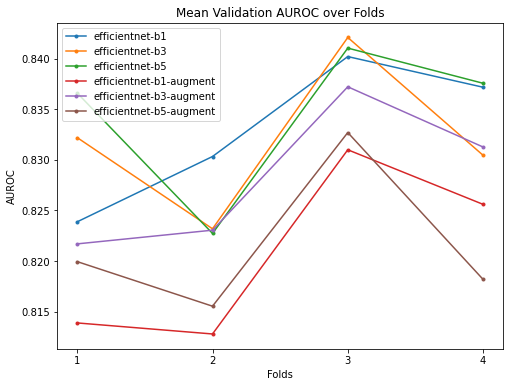

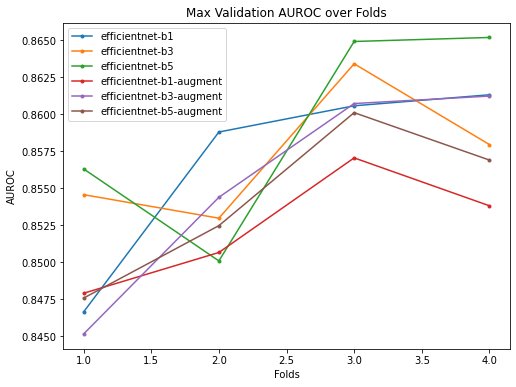

In [13]:
plt.figure(figsize=(8,6))
for j in range(len(aurocs)):
    plt.plot(range(1, len(aurocs[j]) + 1), aurocs_mean[j], label=names[j], marker=".")
plt.xlabel("Folds")
plt.ylabel("AUROC")
plt.xticks(np.arange(1, len(aurocs[j]) + 1, step=1))
plt.legend()
plt.title(f"Mean Validation AUROC over Folds");

plt.figure(figsize=(8,6))
for j in range(len(aurocs)):
    plt.plot(range(1, len(aurocs[j]) + 1), aurocs_max[j], label=names[j], marker=".")
plt.xlabel("Folds")
plt.ylabel("AUROC")
plt.legend()
plt.title(f"Max Validation AUROC over Folds");



The results show that the models trained on augmented data do not lead to a better result. On the contrary, they even performed slightly worse than the models trained on the original data.